# [Introduction to Data Science: A Comp-Math-Stat Approach](https://lamastex.github.io/scalable-data-science/as/2019/)
## 1MS041, 2020 
&copy;2020 Raazesh Sainudiin, Benny Avelin. [Attribution 4.0 International (CC BY 4.0)](https://creativecommons.org/licenses/by/4.0/)

# 11. Non-parametric Estimation and Testing


### Topics

- Nonparametric Estimation
- Glivenko-Cantelli Theorem
- Dvoretsky-Kiefer-Wolfowitz Inequality
- Plug-in Estimator
- Nonparametric Confidence Intervals via Bootstrap
- Nonparametric Hypothesis Testing 
- Permutation Testing
- Permutation Testing with Shells Data

  

## Inference and Estimation: The Big Picture

The Big Picture is about inference and estimation, and especially inference and estimation problems where computational techniques are helpful. 

<table border="1" cellspacing="2" cellpadding="2" align="center">
<tbody>
<tr>
<td style="background-color: #ccccff;" align="center">&nbsp;</td>
<td style="background-color: #ccccff;" align="center"><strong>Point estimation</strong></td>
<td style="background-color: #ccccff;" align="center"><strong>Set estimation</strong></td>
<td style="background-color: #ccccff;" align="center"><strong>Hypothesis Testing</strong></td>
</tr>
<tr>
<td style="background-color: #ccccff;">
<p><strong>Parametric</strong></p>
<p>&nbsp;</p>
</td>
<td style="background-color: #ccccff;" align="center">
<p>MLE of finitely many parameters<br /><span style="color: #3366ff;"><em>done</em></span></p>
</td>
<td style="background-color: #ccccff;" align="center">
<p>Asymptotically Normal Confidence Intervals<br /><span style="color: #3366ff;"><em>done</em></span></p>
</td>
<td style="background-color: #ccccff;" align="center">
<p>Wald Test from Confidence Interval<br /><span style="color: #3366ff;"><em>done</em></span></p>
</td>
</tr>
<tr>
<td style="background-color: #ccccff;">
<p><strong>Non-parametric</strong><br /> (infinite-dimensional parameter space)</p>
</td>
<td style="background-color: #ccccff;" align="center"><strong><em><span style="color: #3366ff;">about to see ... </span></em></strong></td>
<td style="background-color: #ccccff;" align="center"><strong><em><span style="color: #3366ff;">about to see ... </span></em></strong></td>
<td style="background-color: #ccccff;" align="center"><strong><em><span style="color: #3366ff;">about to see ... </span></em></strong></td>
</td>
</tr>
</tbody>
</table>

So far we have seen parametric models, for example

- $X_1, X_2, \ldots, X_n \overset{IID}{\sim} Bernoulli (\theta)$, $\theta \in [0,1]$
- $X_1, X_2, \ldots, X_n \overset{IID}{\sim} Exponential (\lambda)$, $\lambda \in (0,\infty)$
- $X_1, X_2, \ldots, X_n \overset{IID}{\sim} Normal(\mu^*, \sigma)$, $\mu \in \mathbb{R}$, $\sigma \in (0,\infty)$

In all these cases **the parameter space** (the space within which the parameter(s) can take values) is **finite dimensional**:

- for the $Bernoulli$, $\theta \in [0,1] \subseteq \mathbb{R}^1$
- for the $Exponential$, $\lambda \in (0, \infty) \subseteq \mathbb{R}^1$
- for the $Normal$, $\mu \in \mathbb{R}^1$, $\sigma \in (0,\infty) \subseteq \mathbb{R}^1$, so $(\mu, \sigma) \subseteq \mathbb{R}^2$

For parametric experiments, we can use the maximum likelihood principle and estimate the parameters using the **Maximum Likelihood Estimator (MLE)**, for instance. 

# Non-parametric estimation

Suppose we don't know what the distribution function (DF) is?  We are not trying to estimate some fixed but unknown parameter $\theta^*$ for some RV we are assuming to be $Bernoulli(\theta^*)$, we are trying to estimate the DF itself.  In real life, data does not come neatly labeled "I am a realisation of a $Bernoulli$ RV", or "I am a realisation of an $Exponential$ RV": an important part of inference and estimation is to make inferences about the DF itself from our observations.   

#### Observations from some unknown process
<img src="images/unknownProcessTimesAnim.gif" width=400>

Consider the following non-parametric product experiment:

$$X_1, X_2, \ldots, X_n\ \overset{IID}{\sim} F^* \in \{\text{all DFs}\}$$

We want to produce a point estimate for $F^*$, which is a allowed to be any DF ("lives in the set of all DFs"), i.e., $F^* \in \{\text{all DFs}\}$

Crucially, $\{\text{all DFs}\}$, i.e., the set of all distribution functions over $\mathbb{R}$ is infinite dimensional.

<img src="images/TwoDFs.png" width=400>

We have already seen an estimate, made using the data, of a distribution function:  the empirical or data-based distribution function (or empirical cumulative distribution function). This can be formalized as the following process of adding indicator functions of the half-lines beginning at the data points $[X_1,+\infty),[X_2,+\infty),\ldots,[X_n,+\infty)$:

$$\widehat{F}_n (x) = \frac{1}{n} \sum_{i=1}^n \mathbf{1}_{[X_i,+\infty)}(x)$$


where,

$$\mathbf{1}_{[X_i,+\infty)}(x) := \begin{cases} & 1 \quad \text{ if } X_i \leq x \\ & 0 \quad \text{ if }X_i > x \end{cases}$$


First let us evaluate a set of functions that will help us conceptualize faster:

In [12]:
def makeEMFHidden(myDataList):
    '''Make an empirical mass function from a data list.
    
    Param myDataList, list of data to make emf from.
    Return list of tuples comprising (data value, relative frequency) ordered by data value.'''
    
    sortedUniqueValues = sorted(list(set(myDataList)))
    freqs = [myDataList.count(i) for i in sortedUniqueValues]
    relFreqs = [ZZ(fr)/len(myDataList) for fr in freqs] # use a list comprehension
    
    return list(zip(sortedUniqueValues, relFreqs))
    

from pylab import array

def makeEDFHidden(myDataList, offset=0):
    '''Make an empirical distribution function from a data list.
    
    Param myDataList, list of data to make ecdf from.
    Param offset is an offset to adjust the edf by, used for doing confidence bands.
    Return list of tuples comprising (data value, cumulative relative frequency) ordered by data value.'''
    
    sortedUniqueValues = sorted(list(set(myDataList)))
    freqs = [myDataList.count(i) for i in sortedUniqueValues]
    from pylab import cumsum
    cumFreqs = list(cumsum(freqs)) #
    cumRelFreqs = [ZZ(i)/len(myDataList) for i in cumFreqs] # get cumulative relative frequencies as rationals
    if offset > 0: # an upper band
        cumRelFreqs = [min(i ,1) for i in cumRelFreqs] # use a list comprehension
    if offset < 0: # a lower band
        cumRelFreqs = [max(i, 0) for i in cumFreqs] # use a list comprehension
    return list(zip(sortedUniqueValues, cumRelFreqs))
    
# EPMF plot
def epmfPlot(samples):
    '''Returns an empirical probability mass function plot from samples data.'''
    
    epmf_pairs = makeEMFHidden(samples)
    epmf = point(epmf_pairs, rgbcolor = "blue", pointsize="20")
    for k in epmf_pairs:    # for each tuple in the list
        kkey, kheight = k     # unpack tuple
        epmf += line([(kkey, 0),(kkey, kheight)], rgbcolor="blue", linestyle=":")
    # padding
    epmf += point((0,1), rgbcolor="black", pointsize="0")
    return epmf
    

# ECDF plot
def ecdfPlot(samples):
    '''Returns an empirical probability mass function plot from samples data.'''
    ecdf_pairs = makeEDFHidden(samples)
    ecdf = point(ecdf_pairs, rgbcolor = "red", faceted = false, pointsize="20")
    for k in range(len(ecdf_pairs)):
        x, kheight = ecdf_pairs[k]     # unpack tuple
        previous_x = 0
        previous_height = 0
        if k > 0:
            previous_x, previous_height = ecdf_pairs[k-1] # unpack previous tuple
        ecdf += line([(previous_x, previous_height),(x, previous_height)], rgbcolor="grey")
        ecdf += points((x, previous_height),rgbcolor = "white", faceted = true, pointsize="20")
        ecdf += line([(x, previous_height),(x, kheight)], rgbcolor="grey", linestyle=":")
    # padding
    ecdf += line([(ecdf_pairs[0][0]-0.2, 0),(ecdf_pairs[0][0], 0)], rgbcolor="grey")
    max_index = len(ecdf_pairs)-1
    ecdf += line([(ecdf_pairs[max_index][0], ecdf_pairs[max_index][1]),(ecdf_pairs[max_index][0]+0.2, ecdf_pairs[max_index][1])],rgbcolor="grey")
    return ecdf
    
def calcEpsilon(alphaE, nE):
    '''Return confidence band epsilon calculated from parameters alphaE > 0 and nE > 0.'''
    
    return sqrt(1/(2*nE)*log(2/alphaE))

### Let us continue with the concepts

We can remind ourselves of this for a small sample of $de\,Moivre(k=5)$ RVs:

In [13]:
deMs=[randint(1,5) for i in range(20)]  # randint can be used to uniformly sample integers in a specified range
deMs

[1, 4, 4, 1, 4, 3, 3, 3, 3, 5, 1, 2, 1, 1, 2, 3, 1, 2, 4, 4]

In [14]:
sortedUniqueValues = sorted(list(set(deMs)))
freqs = [deMs.count(i) for i in sortedUniqueValues]
from pylab import cumsum
cumFreqs = list(cumsum(freqs)) #
cumRelFreqs = [ZZ(i)/len(deMs) for i in cumFreqs] # get cumulative relative frequencies as rationals
list(zip(sortedUniqueValues, cumRelFreqs))

[(1, 3/10), (2, 9/20), (3, 7/10), (4, 19/20), (5, 1)]

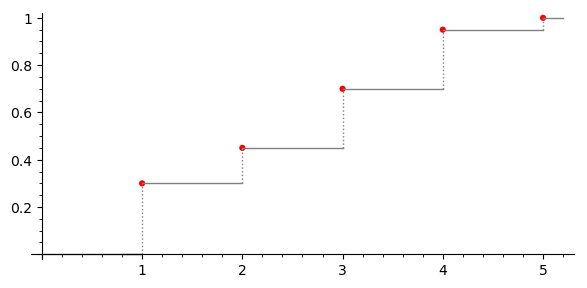

In [15]:
show(ecdfPlot(deMs), figsize=[6,3]) # use hidden ecdfPlot function to plot

We can use the empirical cumulative distribution function $\widehat{F}_n$ for our non-parametric estimate because this kind of estimation is possible in infinite-dimensional contexts due to the following two theorems:

- Glivenko-Cantelli Theorem (*Fundamental Theorem of Statistics*)
- Dvoretsky-Kiefer-Wolfowitz (DKW) Inequality

# Glivenko-Cantelli Theorem

Let $X_1, X_2, \ldots, X_n \overset{IID}{\sim} F^* \in \{\text{all DFs}\}$

and the empirical distribution function (EDF) is $\widehat{F}_n(x) := \displaystyle\frac{1}{n} \sum_{i=1}^n \mathbf{1}_{[X_i,+\infty)}(x)$, then

$$\sup_x { | \widehat{F}_n(x) - F^*(x) | } \overset{P}{\rightarrow} 0$$

Remember that the EDF is a statistic of the data, a statistic is an RV, and (from our work the convergence of random variables), $\overset{P}{\rightarrow}$ means "converges in probability".  The proof is beyond the scope of this course, but we can gain an appreciation of what it means by looking at what happens to the ECDF for $n$ simulations from:

- $de\,Moivre(1/5,1/5,1/5,1/5,1/5)$ and  
- $Uniform(0,1)$ as $n$ increases:

In [16]:
@interact
def _(n=(10,(0..200))):
    '''Interactive function to plot ecdf for obs from de Moirve (5).'''
    if (n > 0):
        us = [randint(1,5) for i in range(n)]
        p=ecdfPlot(us) # use hidden ecdfPlot function to plot
        #p+=line([(-0.2,0),(0,0),(1,1),(1.2,1)],linestyle=':')
        p.show(figsize=[8,2])

Interactive function <function _ at 0x348f63ef0> with 1 widget
  n: SelectionSlider(description='n', index=10,…

In [17]:
@interact
def _(n=(10,(0..200))):
    '''Interactive function to plot ecdf for obs from Uniform(0,1).'''
    if (n > 0):
        us = [random() for i in range(n)]
        p=ecdfPlot(us) # use hidden ecdfPlot function to plot
        p+=line([(-0.2,0),(0,0),(1,1),(1.2,1)],linestyle='-')
        p.show(figsize=[3,3],aspect_ratio=1)

Interactive function <function _ at 0x349402440> with 1 widget
  n: SelectionSlider(description='n', index=10,…

It is clear, that as $n$ increases, the ECDF $\widehat{F}_n$ gets closer and closer to the true DF $F^*$,   $\displaystyle\sup_x { | \widehat{F}_n(x) - F^*(x) | } \overset{P}{\rightarrow} 0$.

This will hold no matter what the (possibly unknown) $F^*$ is.  Thus, $\widehat{F}_n$ is a point estimate of $F^*$.

We need to add the DKW Inequality be able to get confidence sets or a 'confidence band' that traps $F^*$ with high probability.

# Dvoretsky-Kiefer-Wolfowitz (DKW) Inequality

Let $X_1, X_2, \ldots, X_n \overset{IID}{\sim} F^* \in \{\text{all DFs}\}$

and the empirical distribution function (EDF) is $\widehat{F}_n(x) := \displaystyle\frac{1}{n} \sum_{i=1}^n \mathbf{1}_{[X_i,+\infty)}(x)$,

then, for any $\varepsilon > 0$,

$$P\left( \sup_x { | \widehat{F}_n(x) - F^*(x) | > \varepsilon  }\right) \leq 2 \exp(-2n\varepsilon^2) $$

We can use this inequality to get a $1-\alpha$ confidence band $C_n(x) := \left[\underline{C}_n(x), \overline{C}_n(x)\right]$ about our point estimate $\widehat{F}_n$ of our possibly unknown $F^*$ such that the $F^*$ is 'trapped' by the band with probability at least $1-\varepsilon$.

$$\begin{eqnarray} \underline{C}_{\, n}(x) &=& \max \{ \widehat{F}_n(x)-\varepsilon_n, 0 \}, \notag \\ \overline{C}_{\, n}(x) &=& \min \{ \widehat{F}_n(x)+\varepsilon_n, 1 \}, \notag \\ \varepsilon_n &=& \sqrt{ \frac{1}{2n} \log \left( \frac{2}{\alpha}\right)} \\ \end{eqnarray}$$

and

$$P\left(\underline{C}_n(x) \leq F^*(x) \leq \overline{C}_n(x)\right) \geq 1-\alpha$$

 

### YouTry in class

Try this out for a simple sample from the $Uniform(0,1)$, which you can generate using random.   First we  will just make the point estimate for $F^*$, the EDF $\widehat{F}_n$

In [18]:
n=10
uniformSample = [random() for i in range(n)]
print(uniformSample)

[0.3806537803767338, 0.7816332010156033, 0.9819236180032768, 0.20361192055842958, 0.9028173224062944, 0.9051793904661483, 0.9422641171045532, 0.2402003110442763, 0.4881598877072171, 0.34545938150268307]


In one of the assessments, you did a question that took you through the steps for getting the list of points that you would plot for an empirical  distribution function (EDF).  We will do exactly the same thing here.

First we find the unique values in the sample, in order from smallest to largest, and get the frequency with which each unique value occurs:

In [19]:
sortedUniqueValuesUniform = sorted(list(set(uniformSample)))
print(sortedUniqueValuesUniform)

[0.20361192055842958, 0.2402003110442763, 0.34545938150268307, 0.3806537803767338, 0.4881598877072171, 0.7816332010156033, 0.9028173224062944, 0.9051793904661483, 0.9422641171045532, 0.9819236180032768]


In [20]:
freqsUniform = [uniformSample.count(i) for i in sortedUniqueValuesUniform]
freqsUniform

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

Then we accumulate the frequences to get the cumulative frequencies:

In [21]:
from pylab import cumsum
cumFreqsUniform = list(cumsum(freqsUniform)) # accumulate
cumFreqsUniform

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

And the the relative cumlative frequencies:

In [22]:
# cumulative rel freqs as rationals
cumRelFreqsUniform = [ZZ(i)/len(uniformSample) for i in cumFreqsUniform] 
cumRelFreqsUniform

[1/10, 1/5, 3/10, 2/5, 1/2, 3/5, 7/10, 4/5, 9/10, 1]

And finally zip these up with the sorted unique values to get a list of points we can plot:

In [24]:
ecdfPointsUniform = list(zip(sortedUniqueValuesUniform, cumRelFreqsUniform))
ecdfPointsUniform

[(0.20361192055842958, 1/10),
 (0.2402003110442763, 1/5),
 (0.34545938150268307, 3/10),
 (0.3806537803767338, 2/5),
 (0.4881598877072171, 1/2),
 (0.7816332010156033, 3/5),
 (0.9028173224062944, 7/10),
 (0.9051793904661483, 4/5),
 (0.9422641171045532, 9/10),
 (0.9819236180032768, 1)]

Here is a function that you can just use to do a ECDF plot:

In [25]:
# ECDF plot given a list of points to plot
def ecdfPointsPlot(listOfPoints, colour='grey', lines_only=False):
    '''Returns an empirical probability mass function plot from a list of points to plot.
    
    Param listOfPoints is the list of points to plot.
    Param colour is used for plotting the lines, defaulting to grey.
    Param lines_only controls wether only lines are plotted (true) or points are added (false, the default value).
    Returns an ecdf plot graphic.'''
    
    ecdfP = point((0,0), pointsize="0")
    if not lines_only: ecdfP = point(listOfPoints, rgbcolor = "red", faceted = false, pointsize="20")
    for k in range(len(listOfPoints)):
        x, kheight = listOfPoints[k]     # unpack tuple
        previous_x = 0
        previous_height = 0
        if k > 0:
            previous_x, previous_height = listOfPoints[k-1] # unpack previous tuple
        ecdfP += line([(previous_x, previous_height),(x, previous_height)], rgbcolor=colour)
        ecdfP += line([(x, previous_height),(x, kheight)], rgbcolor=colour, linestyle=":")
        if not lines_only: 
            ecdfP += points((x, previous_height),rgbcolor = "white", faceted = true, pointsize="20")
            # padding
    max_index = len(listOfPoints)-1
    ecdfP += line([(listOfPoints[0][0]-0.2, 0),(listOfPoints[0][0], 0)], rgbcolor=colour)
    ecdfP += line([(listOfPoints[max_index][0], listOfPoints[max_index][1]),(listOfPoints[max_index][0]+0.2,\
                                                                listOfPoints[max_index][1])],rgbcolor=colour)
    return ecdfP

This makes the plot of the $\widehat{F}_{10}$, the point estimate for $F^*$ for these $n=10$ simulated samples.

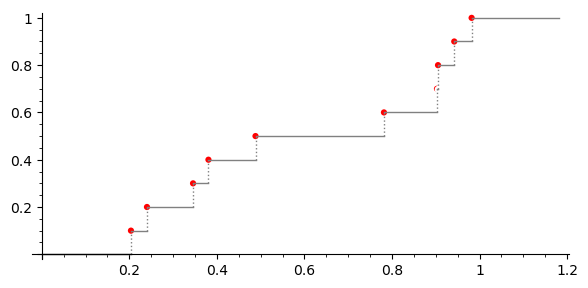

In [26]:
show(ecdfPointsPlot(ecdfPointsUniform), figsize=[6,3])

What about adding those confidence bands?  You will do essentially the same thing, but adjusting for the required $\varepsilon$.  First we need to decide on an $\alpha$ and calculate the $\varepsilon$ corresponding to this alpha.  Here is some of our code to calculate the $\varepsilon$ corresponding to $\alpha=0.05$ (95% confidence bands), using a hidden function calcEpsilon:  

In [27]:
alpha = 0.05
epsilon = calcEpsilon(alpha, n)
epsilon

0.429469408346738

See if you can write your own code to do this calculation, $\varepsilon_n = \sqrt{ \frac{1}{2n} \log \left( \frac{2}{\alpha}\right)}$. For completeness, do the whole thing:assign the value 0.05 to a variable named alpha, and then use this and the variable called n that we have already declared to calculate a value for $\varepsilon$.  Call the variable to which you assign the value for $\varepsilon$  epsilon so that it replaces the value we calculated in the cell above (you should get the same value as us!).

Now we need to use this to adjust the EDF plot.  In the two cells below we first of all do the adjustment for $\underline{C}_{\,n}(x) =\max \{ \widehat{F}_n(x)-\varepsilon_n, 0 \}$, and then use zip again to get the points to actually plot for the lower boundary of the 95% confidence band.

Now we need to use this to adjust the EDF plot. In the two cells below we first of all do the adjustment for $\overline{C}_{\,n}(x) =\min \{ \widehat{F}_n(x)+\varepsilon_n, 1 \}$, and then use zip again to get the points to actually plot for the lower boundary of the 95% confidence band.

In [28]:
# heights for the lower band
cumRelFreqsUniformLower = [max(crf - epsilon, 0) for crf in cumRelFreqsUniform] 
print(cumRelFreqsUniformLower)

[0, 0, 0, 0, 0.0705305916532624, 0.170530591653262, 0.270530591653262, 0.370530591653262, 0.470530591653262, 0.570530591653262]


In [30]:
ecdfPointsUniformLower = list(zip(sortedUniqueValuesUniform, cumRelFreqsUniformLower))
ecdfPointsUniformLower

[(0.20361192055842958, 0),
 (0.2402003110442763, 0),
 (0.34545938150268307, 0),
 (0.3806537803767338, 0),
 (0.4881598877072171, 0.0705305916532624),
 (0.7816332010156033, 0.170530591653262),
 (0.9028173224062944, 0.270530591653262),
 (0.9051793904661483, 0.370530591653262),
 (0.9422641171045532, 0.470530591653262),
 (0.9819236180032768, 0.570530591653262)]

We carefully gave our `ecdfPointsPlo`t function the flexibility to be able to plot bands, by having a colour parameter (which defaults to 'grey') and a `lines_only` parameter (which defaults to `false`).  Here we can plot the lower bound of the confidence interval by adding `ecdfPointsPlot(ecdfPointsUniformLower, colour='green', lines_only=true)` to the previous plot:

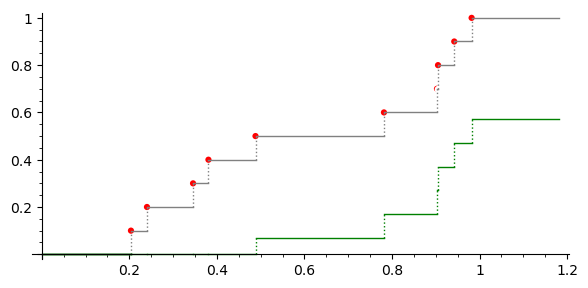

In [31]:
pointEstimate = ecdfPointsPlot(ecdfPointsUniform)
lowerBound = ecdfPointsPlot(ecdfPointsUniformLower, colour='green', lines_only=true)
show(pointEstimate + lowerBound, figsize=[6,3])

### YouTry 
You try writing the code to create the list of points needed for plotting the upper band $\overline{C}_{\,n}(x) =\min \{ \widehat{F}_n(x)+\varepsilon_n, 1 \}$.  You will need to first of all get the upper heights (call them say `cumRelFreqsUniformUpper`) and then `zip` them up with the `sortedUniqueValuesUniform` to get the points to plot.

In [32]:
# heights for the upper band


Once you have got done this you can add them to the plot by altering the code below:

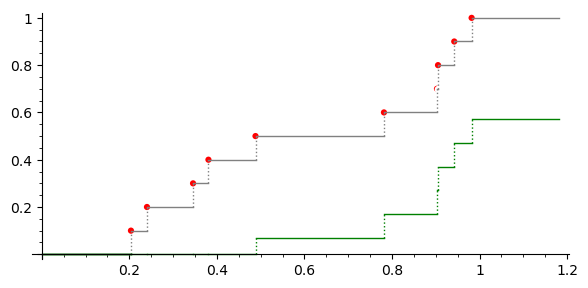

In [33]:
pointEstimate = ecdfPointsPlot(ecdfPointsUniform)
lowerBound = ecdfPointsPlot(ecdfPointsUniformLower,colour='green', lines_only=true)
show(pointEstimate + lowerBound, figsize=[6,3])

(end of YouTry)

---

If we are doing lots of collections of EDF points we may as well define a function to do it, rather than repeating the same code again and again.  We use an offset parameter to give us the flexibility to use this to make points for confidence bands as well.

In [42]:
def makeEDFPoints(myDataList, offset=0):
    '''Make a list empirical distribution plotting points from from a data list.
    
    Param myDataList, list of data to make ecdf from.
    Param offset is an offset to adjust the edf by, used for doing confidence bands.
    Return list of tuples comprising (data value, cumulative relative frequency(with offset)) 
    ordered by data value.'''
    
    sortedUniqueValues = sorted(list(set(myDataList)))
    freqs = [myDataList.count(i) for i in sortedUniqueValues]
    from pylab import cumsum
    cumFreqs = list(cumsum(freqs)) 
    cumRelFreqs = [ZZ(i)/len(myDataList) for i in cumFreqs] # get cumulative relative frequencies as rationals
    if offset > 0: # an upper band
        cumRelFreqs = [min(i+offset ,1) for i in cumRelFreqs]
    if offset < 0: # a lower band
        cumRelFreqs = [max(i+offset, 0) for i in cumRelFreqs] 
    return list(zip(sortedUniqueValues, cumRelFreqs))

## NZ EartQuakes

Now we will try looking at the Earthquakes data we have used before to get a confidence band around an EDF for that.  We start by bringing in the data and the function we wrote earlier to parse that data.

First check if you have already `unzip`-ped `data/earthquakes.csv.zip` file by dropping in shell via `%%sh`.

In [43]:
%%sh
ls data/earthquakes* # the '*' just lists all files that start with earthquakes in data/ directory

data/earthquakes.csv
data/earthquakes.csv.zip
data/earthquakes.tgz
data/earthquakes_small.csv


In [44]:
%%sh
# only do this once! So, you don't need to do this step if you see earthquakes.csv file above
cd data
# windows and mac users should first try to unzip by uncommenting next line
# unzip earthquakes.csv.zip
## if unzip is not found try tar by uncommenting next line and commenting the above line
#tar zxvf earthquakes.tgz
ls -al earthquakes*

-rw-r--r--  1 avelin  staff  4085555 Aug 14 14:06 earthquakes.csv
-rw-r--r--  1 avelin  staff  1344114 Aug 14 14:06 earthquakes.csv.zip
-rw-r--r--  1 avelin  staff  1344959 Aug 14 14:06 earthquakes.tgz
-rw-r--r--  1 avelin  staff    77786 Aug 14 14:06 earthquakes_small.csv


In [45]:
def getLonLatMagDepTimes(NZEQCsvFileName):
    '''returns longitude, latitude, magnitude, depth and the origin time as unix time
    for each observed earthquake in the csv filr named NZEQCsvFileName'''
    from datetime import datetime
    import time
    from dateutil.parser import parse
    import numpy as np
    
    with open(NZEQCsvFileName) as f:
        reader = f.read() 
        dataList = reader.split('\n')
        
    myDataAccumulatorList =[]
    for data in dataList[1:-1]:
        dataRow = data.split(',')
        myTimeString = dataRow[2] # origintime
        # let's also grab longitude, latitude, magnitude, depth
        myDataString = [dataRow[4],dataRow[5],dataRow[6],dataRow[7]]
        try: 
            myTypedTime = time.mktime(parse(myTimeString).timetuple())
            myFloatData = [float(x) for x in myDataString]
            myFloatData.append(myTypedTime) # append the processed timestamp
            myDataAccumulatorList.append(myFloatData)
        except TypeError as e: # error handling for type incompatibilities
            print ('Error:  Error is ', e)
    #return np.array(myDataAccumulatorList)
    return myDataAccumulatorList

myProcessedList = getLonLatMagDepTimes('data/earthquakes.csv')

def interQuakeTimes(quakeTimes):
    '''Return a list inter-earthquake times in seconds from earthquake origin times
    Date and time elements are expected to be in the 5th column of the array
    Return a list of inter-quake times in seconds. NEEDS sorted quakeTimes Data'''
    import numpy as np
    retList = []
    if len(quakeTimes) > 1:
        retList = [quakeTimes[i]-quakeTimes[i-1] for i in range(1,len(quakeTimes))]
    #return np.array(retList)
    return retList

interQuakesSecs = interQuakeTimes(sorted([x[4] for x in myProcessedList]))
len(interQuakesSecs)

21015

In [46]:
interQuakesSecs[0:10]

[531.0, 551.0, 764.0, 294.0, 678.0, 1538.0, 376.0, 364.0, 208.0, 242.0]

There is a lot of data here, so let's use an interactive plot to do the non-parametric DF estimation just for some of the last data:

In [47]:
@interact
def _(takeLast=(500,(0..min(len(interQuakesSecs),1999))), alpha=input_box(0.05.n(digits=3),label='$\\alpha$')):
    '''Interactive function to plot the edf estimate and confidence bands for inter earthquake times.'''
    if takeLast > 0 and alpha > 0 and alpha < 1:
        lastInterQuakesSecs = interQuakesSecs[len(interQuakesSecs)-takeLast:len(interQuakesSecs)]
        interQuakePoints = makeEDFPoints(lastInterQuakesSecs)
        p=ecdfPointsPlot(interQuakePoints, lines_only=true)
        epQuakes = calcEpsilon(alpha, len(lastInterQuakesSecs))
        interQuakePointsLower = makeEDFPoints(lastInterQuakesSecs, offset=-epQuakes)
        lowerQuakesBound = ecdfPointsPlot(interQuakePointsLower, colour='green', lines_only=true)
        interQuakePointsUpper = makeEDFPoints(lastInterQuakesSecs, offset=epQuakes)
        upperQuakesBound = ecdfPointsPlot(interQuakePointsUpper, colour='green', lines_only=true)
        show(p + lowerQuakesBound + upperQuakesBound, figsize=[6,3])
    else:
        print ("check your input values")

Interactive function <function _ at 0x349813c20> with 2 widgets
  takeLast: SelectionSlider(description='takeL…

# Plug-in Estimator: A nonparametric Point Estimator 

A function $h$ of another function $g$ is called a *functional*. A **statistical functional** $T(F)$ is any function of the distribution function $F$.

Suppose we are not directly interested in estimating the unknown $F^*$ in the experiment with $n$ IID samples: 
$$X_1,\ldots,X_n \overset{IID}{\sim}F^* \in \{ \text{ all DFs } \}$$
But rather in estimating a statistical functional of interest, say, $\theta^* := T(F^*)$.

NOTE: Here $\theta^*$ is not a parameter, but just some unknown quantity of interest that can be obtained as a statistical functional $T(F^*)$ of the unknown $F^*$.

Some examples of statistical functionals you have already seen include:

-  The expectation of $g(X)$ is a functional as it merely involves the integration against $dF(x)$
  - Mean with $g(X)=X$: 
    $$E(X) = \int x \, d F(x) = \begin{cases} \int x \, f(x) dx & \text{ if $X$ is a continuous distribution with probability density function $f(x)$}\\ \sum_x x \, f(x) & \text{ if $X$ is a discrete distribution with probability mass function $f(x)$}\end{cases}$$
  - Variance with $g(X)=(X-E(X))^2$:
    $$V(X) = \int (x-E(X))^2 \, d F(x)$$
- Another interesting staistical function is the median:
  - Median as the inverse of the DF at $0.5$:
    $$\mathrm{median}(X) = F^{[-1]}(0.5)$$

By substituting in the point estimate $\widehat{F}_n$ for the unknown $F^*$, we can obtain the **plug-in estimator** as:
$$
\boxed{
\widehat{\Theta}_n = T(\widehat{F}_n) \quad
\text{ of the quantity of interest } \, \theta^* := T(F^*)
}
$$
In other words, just plug-in $\widehat{F}_n$ for the unknown $F^*$ in $T(F^*) =: \theta^*$. 

If $T(F)=\int r(x) \, d F(x)$ for some function $r(x)$ then $T$ is called a **linear functional** since $T$ is linear in its arguments: $T(aF+bG)=aT(F)+bT(G)$, where $(a,b) \in \mathbb{R}^2$.

Thus, the plug-in estimator for any linear statistical functional $\theta^* = T(F^*)=\int r(x) dF^*(x)$ is:

$$
\boxed{\widehat{\Theta}_n = T(\widehat{F}_n) = \frac{1}{n} \sum_{i=1}^n r(x_i)}
$$
because:
$$
\widehat{\Theta}_n = T(\widehat{F}_n) = \int r(x) d \widehat{F}_n(x) = \sum_{i=1}^n r(x_i) \, P(X=x_i) = \sum_{i=1}^n r(x_i) \, f(x_i) = \sum_{i=1}^n r(x_i) \, \frac{1}{n} = \frac{1}{n} \sum_{i=1}^n r(x_i)
$$

Sample mean and sample variance are actually examples of plug-in estimators of the linear statistical functionals $E(X)$ and $V(X)$
  - Sample Mean: 
    $$\overline{X}_n = \int x \, d \widehat{F}_n(x) = \frac{1}{n} \sum_{i=1}^n x_i$$
  - Sample Variance:
    $$\mathrm{var}(X_n) = \int (x-\overline{X}_n)^2 \, d \widehat{F}_n(x) = \frac{1}{n} \sum_{i=1}^n \left( x_i - \overline{X}_n\right)^2$$
    
Quantiles generalise the notion of a median and are very useful statistics when we want to summarise the values taken by a random variable. For a given $q \in (0,1)$, **the $q$-th quantile** of a random variable with DF $F$ is the statistical functional: 
$$T(F)={F}^{[-1]}(q) := \inf\{x: F(x) \geq q\}$$
We can use the plug-in estimator:
$$\widehat{F}_n^{[-1]}(q) := \inf\{x: \widehat{F}_n(x) \geq q\}$$
to estimate $T(F)={F}^{[-1]}(q)$, and $\widehat{F}_n^{[-1]}(q)$ is called the **$q$-th sample quantile**

### Example:  Estimating quantiles of inter-earthquake times

We can simply call the quantile function knowing that it is just a plug-in estimator of the $q$-th quantile.

#### Quantiles and Percentiles
If $q \in [0,100]$ then we call $(\frac{q}{100})$-th quantile as the $q$-th percentile.

In [48]:
import numpy as np
iQMinutes = np.array(interQuakesSecs)/60.0
np.percentile(iQMinutes,95.0) # percentile
# is in range (0,100) corresponding to quantile in (0,1)

75.255

So only $5\%=0.05$ of the inter-EQ times are longer than 75 minutes. If we assume this non-parametric model that  models the times between EQs as IID RVs, then the probability of not have any earthquakes in New Zealand (during the observation period) for longer than 150 minutes is no smaller than $0.05 \times 0.05 = 0.0025 = 1/400$, a pretty unlikely event!

Quantiles as plug-in estimates can give us a lot of basic insights into the data under the more general nonparametric view.

In [50]:
print ("minimum, maximum inter EQ-time in minues = ", min(iQMinutes), max(iQMinutes))

print ("(0.05-th, 0.50-th or median, 0.95-th) quantiles = ",\
(np.percentile(iQMinutes,5.0),np.percentile(iQMinutes,50.0), np.percentile(iQMinutes,95.0)))


minimum, maximum inter EQ-time in minues =  0.0 327.8
(0.05-th, 0.50-th or median, 0.95-th) quantiles =  (1.3166666666666667, 15.516666666666667, 75.255)


# Bootstrap for Confidence Sets in Nonparametric Experiments 

> This is an adaptation of *All of Statistics (2003)* by Wasserman of Carnegie Mellon University, Pittsburgh, PA, USA (one of the first universities that started presenting an integrated research and educational view of mathematical statistics and machine learning, along both theoretical and applied fronts).

Plug-in estimators are point estimators. Next we will see a very general way to obtain set estimators of $\theta^* = T(F^*)$, some statistical functional of interest, when we do not make any parametric assumptions about the underlying unknown distribution function $F^*$ in our IID experiment:

$$X_1,\ldots,X_n \overset{IID}{\sim}F^* \in \{ \text{ all DFs } \}$$

NOTE: To get confidence sets (or intervals in 1D) we need to obtain estimated standard error $\widehat{se}_n$ of our point estimator, such as the plug-in estimator, $\widehat{\Theta}_n$ of $\theta^*=T(F^*)$. This is generally not possible. However, the bootstrap due to Efron gives us a helping hand.

The **bootstrap** is a statistical method for estimating standard errors and confidence sets of statistics, such as estimators.

Let $T_n := T_n((X_1,X_2,\ldots,X_n))$ be a statistic, i.e, any function of the data $X_1,X_2,\ldots,X_n \overset{IID}{\sim} F^*$.  

Suppose we want to know its variance $V_{F^*}(T_n)$, which clearly depends on the fixed and possibly unknown DF $F^*$ (hence the subscripting by $F^*$ to emphasise this dependence).

If our statistic $T_n$ is one with an analytically unknown variance, then we can use the bootstrap to estimate it.  

The bootstrap idea has the following **two basic steps** with their underlying assumptions:

- $\mathsf{Step~1}$: *Estimate* $V_{F^*}(T_n)$ with $V_{\widehat{F}_n}(T_n)$.
  - Here we are assuming that $n$ is large enough so that $\widehat{F}_n$ is a good approximation of $F^*$.
- $\mathsf{Step~2}$: *Approximate* $V_{\widehat{F}_n}(T_n)$ using simulated data from the "Bootstrap World." (Glivenko-Cantelli Theorem and Dvoretzky-Kiefer-Wolfowitz Inequality)
  - Here we are assuming that the simulated data is available $B$ times for large enough $B$ to approximate $V_{\widehat{F}_n}(T_n)$ (Law of Large Numbers)


For example, if $T_n=\overline{X}_n$, in $\mathsf{Step~1}$, $V_{\widehat{F}_n}(T_n) = s_n^2/n$, where $s_n^2=n^{-1} \sum_{i=1}^n (x_i-\overline{x}_n)$ is the sample variance and $\overline{x}_n$ is the sample mean.  In this case,  $\mathsf{Step~1}$ is enough.  However, when the statistic $T_n$ is more complicated (e.g. $T_n=\widetilde{X}_n = F^{[-1]}(0.5)$), the sample median, then we may not be able to find a simple expression for $V_{\widehat{F}_n}(T_n)$ and may need $\mathsf{Step~2}$ of the bootstrap.

$$
\boxed{
\begin{eqnarray}
\text{Real World Data come from} &  F^* \quad \implies X_1,X_2,\ldots,X_n & \implies
T_n((X_1,X_2,\ldots,X_n))=t_n \notag \\
\text{Bootstrap World Data come from} & \widehat{F}_n \quad  \implies X^{\bullet}_1,X^{\bullet}_2,\ldots,X^{\bullet}_n & \implies
T_n((X^{\bullet}_1,X^{\bullet}_2,\ldots,X^{\bullet}_n))=t^{\bullet}_n \notag
\end{eqnarray}
}
$$

Observe that drawing an observation from the empirical DF $\widehat{F}_n$ is equivalent to drawing one point at random from the original data (think of the indices $[n] := \{ 1,2,\ldots,n \}$ of the original data $X_1,X_2,\ldots,X_n$ being drawn according to the equi-probable $de~Moivre(1/n,1/n,\ldots,1/n)$ RV on $[n]$).  Thus, to simulate $X^{\bullet}_1,X^{\bullet}_2,\ldots,X^{\bullet}_n$ from $\widehat{F}_n$, it is enough to drawn $n$ observations with replacement from the dataset $\{X_1,X_2,\ldots,X_n\}$.

In summary, the algorithm for Bootstrap Variance Estimation is:


> - $\mathsf{Step~1}$: Draw $X^{\bullet}_1,X^{\bullet}_2,\ldots,X^{\bullet}_n \sim \widehat{F}_n$
> - $\mathsf{Step~2}$: Compute $t_n^{\bullet} = T_n((X^{\bullet}_1,X^{\bullet}_2,\ldots,X^{\bullet}_n))$
> - $\mathsf{Step~3}$: Repeat $\mathsf{Step~1}$ and $\mathsf{Step~2}$ $B$ times, for some large $B$, say $B>1000$, to get $t_{n,1}^{\bullet}, t_{n,2}^{\bullet},\ldots,t_{n,B}^{\bullet}$
> - $\mathsf{Step~4}$: Several ways of estimating the bootstrap confidence intervals are possible, we use the one based on percentiles:
>  - The $1-\alpha$ percentile-based bootstrap confidence interval is:
$$
C_n=[\widehat{G^{\bullet}}_{n}^{-1}(\alpha/2),\widehat{G^{\bullet}}_{n}^{-1}(1-\alpha/2)] ,
$$
> where $\widehat{G^{\bullet}}_{n}$ is the empirical DF of the bootstrapped $t_{n,1}^{\bullet}, t_{n,2}^{\bullet},\ldots,t_{n,B}^{\bullet}$ and $\widehat{G^{\bullet}}_{n}^{-1}(q)$ is the $q^{\text{th}}$ sample quantile of $t_{n,1}^{\bullet}, t_{n,2}^{\bullet},\ldots,t_{n,B}^{\bullet}$.


## Confidence Interval via Bootstrap - Median of inter-EQ Times in Minutes

Use Bootstrap to obtain a 95% confidence interval of the median inter earth-quate time in minutes. Use this interval to test the null hypothesis that the median inter earth-quate time is 10 minutes.


In [53]:
# Sample Exam Problem x - Solution
# Be patient! this can take a couple minutes; reduce B to 100 to save time
import numpy as np
iQMinutes = np.array(interQuakesSecs)/60.0
sampleMedian = np.percentile(iQMinutes,50.0) # median 
print ("The sample median = ",sampleMedian)

B = 1000 # Number of Bootstrap replications
n = len(iQMinutes) # sample size of the original dataset
bootstrappedSampleMedians=[] # list to store the sample medians from each bootstrapped data
for b in range(B):
    #sample indices at random between 0 and len(iQMinutes)-1 to make the bootstrapped dataset
    randIndices=[randint(0,n-1) for i in range(n)] 
    bootstrappedDataset = iQMinutes[randIndices] # resample with replacement from original dataset
    bootstrappedMedian = np.percentile(bootstrappedDataset,50.0)
    bootstrappedSampleMedians.append(bootstrappedMedian)

lower95BootstrapCIForMedian = np.percentile(bootstrappedSampleMedians,2.5)
upper95BootstrapCIForMedian = np.percentile(bootstrappedSampleMedians,97.5)

print ("The inner 95% percentile based Confidence Interval for the Median = ")
print ("[ "+str(lower95BootstrapCIForMedian) + " , " + str(upper95BootstrapCIForMedian) +" ]")

The sample median =  15.516666666666667
The inner 95% percentile based Confidence Interval for the Median = 
[ 15.133333333333333 , 15.866666666666667 ]


## Testing via Bootstrap 

We can use bootstrap-based confidence interval in conjunction with Wald test in nonparametric experiments just as we used confidence interval from an asymptotically normal estimator such as the MLE in the parametric experiments.

### The $\mathsf{size}$ Wald test from bootstrapped $1-\alpha$ Confidence Interval $C_n$ for a statistic $t$

The $\mathsf{size}$ $\alpha$ Wald test rejects:

$$
\boxed{
\text{ $H_0: t^*=t_0$ versus $H_1: t^* \neq t_0$ if and only if $t_0 \notin C_n := C_n=[\widehat{G^{\bullet}}_{n}^{-1}(\alpha/2),\widehat{G^{\bullet}}_{n}^{-1}(1-\alpha/2)]$.
}}
$$

$$\boxed{\text{Therefore, testing the hypothesis is equivalent to verifying whether the null value $t_0$ is in the bootstrapped confidence interval.}}$$



### Example: Wald Test that median of inter-EQ times is 10 minutes

We reject the null hypothesis that the median is $10$ minutes, if $10$ is not inside the 95% confidence interval for the median we just obtained via bootstrap. This is just like the Wald test except that we use the bootstrap instead of the asymptotic normality of the maximum likelihood estimator.

Let us see this more explicitly in the next cell.

In [55]:
### Example: Wald Test that median of inter-EQ times is 10 minutes
#### Be patient if you see a 'In [*]' to the left top corner of the cell ... your computer is working...
nullValueForMedian = 10.0

# check if the null value is in the 95% CI or not to fail to reject or reject the null hypothesis
if nullValueForMedian >= lower95BootstrapCIForMedian and nullValueForMedian <= upper95BootstrapCIForMedian:
    print ("The null value for median = "+str(nullValueForMedian)+\
    "\nis inside the 95% Bootstrapped Confidence Interval: "+\
    "[ "+str(lower95BootstrapCIForMedian) + " , " + str(upper95BootstrapCIForMedian) +" ]")
    print ("        Therefore, we fail to reject the null hypothesis H_0: median=1.0")
else:
    print ("The null value for median = "+str(nullValueForMedian)+\
    "\nis NOT inside the 95% Bootstrapped Confidence Interval: "+\
    "[ "+str(lower95BootstrapCIForMedian) + " , " + str(upper95BootstrapCIForMedian) +" ]")
    print ("        Therefore, we reject the null hypothesis H_0: median = "+str(nullValueForMedian))
    

The null value for median = 10.0000000000000
is NOT inside the 95% Bootstrapped Confidence Interval: [ 15.133333333333333 , 15.866666666666667 ]
        Therefore, we reject the null hypothesis H_0: median = 10.0000000000000


### Making a Generic Bootstrap Function for $1-\alpha$ Confidence Interval of any Statistic

Making a generic function `makeBootstrappedConfidenceIntervalOfStatisticT` as done below can be helpful in other problems.

In [56]:
import numpy as np

def makeBootstrappedConfidenceIntervalOfStatisticT(dataset, statT, alpha, B=100):
    '''make a bootstrapped 1-alpha confidence interval for ANY given statistic statT 
    from the dataset with B Bootstrap replications for 0 < alpha < 1, and 
    return lower CI, upper CI, bootstrapped_samples '''
    n = len(dataset) # sample size of the original dataset
    bootstrappedStatisticTs=[] # list to store the statistic T from each bootstrapped data
    for b in range(B):
        #sample indices at random between 0 and len(iQMinutes)-1 to make the bootstrapped dataset
        randIndices=[randint(0,n-1) for i in range(n)] 
        bootstrappedDataset = dataset[randIndices] # resample with replacement from original dataset
        bootstrappedStatisticT = statT(bootstrappedDataset)
        bootstrappedStatisticTs.append(bootstrappedStatisticT)
    # noe get the [2.5%, 97.5%] percentile-based CI
    alpaAsPercentage=alpha*100.0
    lowerBootstrap1MinusAlphaCIForStatisticT = np.percentile(bootstrappedStatisticTs,alpaAsPercentage/2)
    upperBootstrap1MinusAlphaCIForStatisticT = np.percentile(bootstrappedStatisticTs,100-alpaAsPercentage/2)
    return (lowerBootstrap1MinusAlphaCIForStatisticT,upperBootstrap1MinusAlphaCIForStatisticT,\
            np.array(bootstrappedStatisticTs))

## Demonstrating the use of bootstrap for different statistics of interest

We can obtain the bootstrap-based $1-\alpha$ confidence intervals quite easily for any statistic and any dataset as demonstrated below.

### Bootstrapped $1-\alpha$ Confidence Interval for Sample Median of inter-EQ Time in Minutes

All we need to do is follow these **three steps to perform a bootstrap**:

1. define a lambda expression for the statistic of interest: `statTMedian = lambda dataset : np.percentile(dataset,50.0)` 
- get the plugin estimate : `statTMedian = lambda dataset : np.percentile(dataset,50.0)`
- and call the generic function we made:
>   `lowerCIMedian,upperCIMedian,bootValuesMedian = \`
>    `                          makeBootstrappedConfidenceIntervalOfStatisticT(iQMinutes, statTMedian, alpha, B)`

In [58]:
#### Be patient if you see a 'In [*]' to the left top corner of the cell ... your computer is working...
# dataset
iQMinutes = np.array(interQuakesSecs)/60.0

# our statistic T as one example, say the 50-th percentile or median as  
# via anonymous function / lambda expression
statTMedian = lambda dataset : np.percentile(dataset,50.0)

# now obtain the bootstrapped 1-alpha confidence interval with alpha=0.5, i.e. 95% conf Interval
alpha=0.05
B=100 # number of bootstrap samples

# plug-in point estimate of population median of inter-EQ times
plugInEstimateOfMedian = statTMedian(iQMinutes)

# Let's call our convenient function
# and get the bootstrapped samples and build 1-alpha confidence interval
lowerCIMedian,upperCIMedian,bootValuesMedian = \
           makeBootstrappedConfidenceIntervalOfStatisticT(iQMinutes, statTMedian, alpha, B)

# print the results
print ("The Plug-in Point Estimate of the Population Median of inter-EQ Times  = ", plugInEstimateOfMedian)
print ("1-alpha Bootstrapped CI for the media of inter-EQ Times = ", (lowerCIMedian,upperCIMedian))
print ("         where alpha = ",alpha.n(digits=2)," and bootstrap replicates = ", B)

The Plug-in Point Estimate of the Population Median of inter-EQ Times  =  15.516666666666667
1-alpha Bootstrapped CI for the media of inter-EQ Times =  (15.164166666666667, 15.825416666666666)
         where alpha =  0.050  and bootstrap replicates =  100


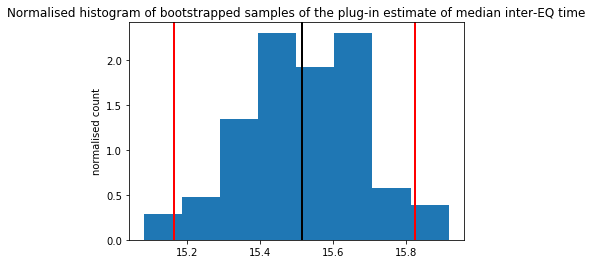

In [59]:
import pylab
pylab.clf() # clear current figure
Bins=8 # Number of histogram bins
n, bins, patches = pylab.hist(bootValuesMedian, Bins, density=true) 
pylab.ylabel('normalised count')
pylab.title('Normalised histogram of bootstrapped samples of the plug-in estimate of median inter-EQ time')
pylab.axvline(x=plugInEstimateOfMedian, linewidth=2, color='k') # plot vertical line at plug-in point estimate
pylab.axvline(x=lowerCIMedian, linewidth=2, color='r') # plot vertical line at lower CI at (alpha/2)-th Quantile
pylab.axvline(x=upperCIMedian, linewidth=2, color='r') # plot vertical line at upper CI at (1-alpha/2)-th Quantile
#pylab.savefig('myHist') # to actually save the figure for subsequent extraction elsewhere
pylab.show()

### CAUTION: Bootstrap is justified if two of its assumptions are satisfied:

Recall assumptions in **the two basic steps** in the Bootstrap from above (notebook `11.ipynb`): 
1. $\mathsf{Step~1}$: $n$ is large enough, so that the empirical DF $\widehat{F}_n$ is a good approximation for the unknown $F^*$ in the model $X_1,X_2,\ldots,X_n \overset{IID}{\sim} F^*$, and
- $\mathsf{Step~2}$: $B$, the number of bootstrap samples is large enough.

So it is a good idea to increase $B$ to $1000$ or perhaps more (depending on the problem and available computational resources) to see how the results are affected. Remember, the confidence intervals will slightly change due to random seed in the simulation and your values for $n$ and $B$.

NOTE: When the dataset is much larger in size (order of billions or hundreds of billions) or not IID real-valued but perhaps dependent (eg. time series models) then there are other sub-sampling schemes that one may need to use under further assumptions on the model.

# Sample Exam Problem 7

Obtain the plug-in estimate of the population median of inter-EQ times in minutes stored in the array `iQMinutes`. 
Using $1000$ bootstrap replicates $B$, obtain the the 95% confidence interval for the median inter-EQ time in minutes.
Using a Wald-like Test based on the bootstrapped 95% confidence interval, test the null hypothesis that the inter-EQ time is 20 minutes (just report the finding of your test through the boolean `RejectedH0_sampleMedianIs20min` ).

NOTE: Make Sure you run the `REQUIRED-CELL` before trying the Problem.

In [61]:
# Sample Exam Problem 7 - REQUIRED-CELL

# DO NOT MODIFY this cell 
# Evaluate this cell before trying this PROBLEM so that the required functions and variables are loaded

import numpy as np
## Be Patient! - This will take more time, about a minute or so
###############################################################################################
def getLonLatMagDepTimes(NZEQCsvFileName):
    '''returns longitude, latitude, magnitude, depth and the origin time as unix time
    for each observed earthquake in the csv filr named NZEQCsvFileName'''
    from datetime import datetime
    import time
    from dateutil.parser import parse
    import numpy as np
    
    with open(NZEQCsvFileName) as f:
        reader = f.read() 
        dataList = reader.split('\n')
        
    myDataAccumulatorList =[]
    for data in dataList[1:-1]:
        dataRow = data.split(',')
        myTimeString = dataRow[2] # origintime
        # let's also grab longitude, latitude, magnitude, depth
        myDataString = [dataRow[4],dataRow[5],dataRow[6],dataRow[7]]
        try: 
            myTypedTime = time.mktime(parse(myTimeString).timetuple())
            myFloatData = [float(x) for x in myDataString]
            myFloatData.append(myTypedTime) # append the processed timestamp
            myDataAccumulatorList.append(myFloatData)
        except TypeError as e: # error handling for type incompatibilities
            print ('Error:  Error is ', e)
    #return np.array(myDataAccumulatorList)
    return myDataAccumulatorList

myProcessedList = getLonLatMagDepTimes('data/earthquakes.csv')

def interQuakeTimes(quakeTimes):
    '''Return a list inter-earthquake times in seconds from earthquake origin times
    Date and time elements are expected to be in the 5th column of the array
    Return a list of inter-quake times in seconds. NEEDS sorted quakeTimes Data'''
    import numpy as np
    retList = []
    if len(quakeTimes) > 1:
        retList = [quakeTimes[i]-quakeTimes[i-1] for i in range(1,len(quakeTimes))]
    #return np.array(retList)
    return retList

def makeBootstrappedConfidenceIntervalOfStatisticT(dataset, statT, alpha, B=100):
    '''make a bootstrapped 1-alpha confidence interval for ANY given statistic statT 
    from the dataset with B Bootstrap replications for 0 < alpha < 1, and 
    return lower CI, upper CI, bootstrapped_samples '''
    n = len(dataset) # sample size of the original dataset
    bootstrappedStatisticTs=[] # list to store the statistic T from each bootstrapped data
    for b in range(B):
        #sample indices at random between 0 and len(iQMinutes)-1 to make the bootstrapped dataset
        randIndices=[randint(0,n-1) for i in range(n)] 
        bootstrappedDataset = dataset[randIndices] # resample with replacement from original dataset
        bootstrappedStatisticT = statT(bootstrappedDataset)
        bootstrappedStatisticTs.append(bootstrappedStatisticT)
    # noe get the [2.5%, 97.5%] percentile-based CI
    alpaAsPercentage=alpha*100.0
    lowerBootstrap1MinusAlphaCIForStatisticT = np.percentile(bootstrappedStatisticTs,alpaAsPercentage/2)
    upperBootstrap1MinusAlphaCIForStatisticT = np.percentile(bootstrappedStatisticTs,100-alpaAsPercentage/2)
    return (lowerBootstrap1MinusAlphaCIForStatisticT,upperBootstrap1MinusAlphaCIForStatisticT,\
            np.array(bootstrappedStatisticTs))

interQuakesSecs = interQuakeTimes(sorted([x[4] for x in myProcessedList]))
iQMinutes = np.array(interQuakesSecs)/60.0
###############################################################################################

In [63]:
# Sample Exam Problem 7
# first evaluate the REQUIRED-CELL above
# Do NOT change the variable or function Names - Just replace XXXs
# now obtain the bootstrapped 1-alpha confidence interval with alpha=0.5, i.e. 95% conf Interval
alpha=0.05
B=1000 # number of bootstrap samples=1000
# our statistic T as one example, say the 50-th percentile or median as  
# via anonymous function / lambda expression
statTMedian = lambda dataset : XXXX

# plug-in point estimate of population median of inter-EQ times
plugInEstimateOfMedian = statTMedian(iQMinutes)

# Let's call our convenient function
# and get the bootstrapped samples and build 1-alpha confidence interval
lowerCIMedian,upperCIMedian,bootValuesMedian = \
           makeBootstrappedConfidenceIntervalOfStatisticT(XXX, XXX, alpha, B)

# print in more details if you want to see if your values make sense
print ("The Plug-in Point Estimate of the Population Median of inter-EQ Times  = ", plugInEstimateOfMedian)
print ("1-alpha Bootstrapped CI for the media of inter-EQ Times = ", (lowerCIMedian,upperCIMedian))
print ("         where alpha = ",alpha.n(digits=2)," and bootstrap replicates = ", B)

print (plugInEstimateOfMedian,lowerCIMedian,upperCIMedian)

# Hypothesis test
NullValueForMedian=20 # 20 minutes is the value of Median under the Null Hypothesis, H_0: Population Median = 20
RejectedH0_sampleMedianIs20min = (NullValueForMedian <= XXX and NullValueForMedian >= XXX)

if RejectedH0_sampleMedianIs20min:
    print (" RejectedH0_sampleMedianIs20min = True, so the Null Hypothesis is Rejected at size alpha = ",alpha)
else:
    print (" RejectedH0_sampleMedianIs20min = False, so the Null Hypothesis is NOT Rejected at size alpha = ",alpha)


NameError: name 'XXXX' is not defined

# Sample Exam Problem 7 Solution

The Plug-in Point Estimate of the Population Median of inter-EQ Times  =  15.516666666666667
1-alpha Bootstrapped CI for the media of inter-EQ Times =  (15.183333333333334, 15.825416666666666)
         where alpha =  0.050  and bootstrap replicates =  100
15.516666666666667 15.183333333333334 15.825416666666666
 RejectedH0_sampleMedianIs20min = False, so the Null Hypothesis is NOT Rejected at size alpha =  0.0500000000000000


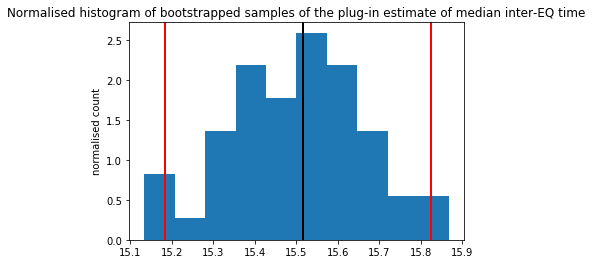

In [64]:
# Sample Exam Problem 7 - SOLUTION
#### Be patient if you see a 'In [*]' to the left top corner of the cell ... your computer is working...
# Do NOT change the variable or function Names - Just replace XXXs
# now obtain the bootstrapped 1-alpha confidence interval with alpha=0.5, i.e. 95% conf Interval
alpha=0.05
B=100 # number of bootstrap samples=1000
# our statistic T as one example, say the 50-th percentile or median as  
# via anonymous function / lambda expression
statTMedian = lambda dataset : np.percentile(dataset,50.0)

# plug-in point estimate of population median of inter-EQ times
plugInEstimateOfMedian = statTMedian(iQMinutes)

# Let's call our convenient function
# and get the bootstrapped samples and build 1-alpha confidence interval
lowerCIMedian,upperCIMedian,bootValuesMedian = \
           makeBootstrappedConfidenceIntervalOfStatisticT(iQMinutes, statTMedian, alpha, B)

# print in more details if you want to see if your values make sense
print ("The Plug-in Point Estimate of the Population Median of inter-EQ Times  = ", plugInEstimateOfMedian)
print ("1-alpha Bootstrapped CI for the media of inter-EQ Times = ", (lowerCIMedian,upperCIMedian))
print ("         where alpha = ",alpha.n(digits=2)," and bootstrap replicates = ", B)

print (plugInEstimateOfMedian,lowerCIMedian,upperCIMedian)

# Hypothesis test
NullValueForMedian=20 # 20 minutes is the value of Median under the Null Hypothesis, H_0: Population Median = 20

RejectedH0_sampleMedianIs20min = (NullValueForMedian <= upperCIMedian and NullValueForMedian >= lowerCIMedian)

if RejectedH0_sampleMedianIs20min:
    print (" RejectedH0_sampleMedianIs20min = True, so the Null Hypothesis is Rejected at size alpha = ",alpha)
else:
    print (" RejectedH0_sampleMedianIs20min = False, so the Null Hypothesis is NOT Rejected at size alpha = ",alpha)

# This is just extra stuff you don't need to do for this sample exam problem!
import pylab
pylab.clf() # clear current figure
Bins=10 # Number of histogram bins
n, bins, patches = pylab.hist(bootValuesMedian, Bins, density=true) 
pylab.ylabel('normalised count')
pylab.title('Normalised histogram of bootstrapped samples of the plug-in estimate of median inter-EQ time')
pylab.axvline(x=plugInEstimateOfMedian, linewidth=2, color='k') # plot vertical line at plug-in point estimate
pylab.axvline(x=lowerCIMedian, linewidth=2, color='r') # plot vertical line at lower CI at (alpha/2)-th Quantile
pylab.axvline(x=upperCIMedian, linewidth=2, color='r') # plot vertical line at upper CI at (1-alpha/2)-th Quantile
#pylab.savefig('myHist') # to actually save the figure for subsequent extraction elsewhere
pylab.show()

---
## Assignment 3, PROBLEM 7
Maximum Points = 2


Repeat the **three steps to perform a bootstrap** above as done in **Median of inter-EQ Time** example (notebook `11.ipynb`) to find the plug-in estimate and 95% CI for the *99-th Percentile of the inter-EQ time in minutes*.

You just need to evaluate the next `REQUIRED-CELL` and replace `XXX` with the right expressions in the following cell.

HINT: Median is the $50$-th Percentile.

In [66]:
# REQUIRED-CELL

# DO NOT MODIFY this cell 
# Evaluate this cell before trying this PROBLEM so that the required functions and variables are loaded
import numpy as np
## Be Patient! - This will take more time, about a minute or so
###############################################################################################
def getLonLatMagDepTimes(NZEQCsvFileName):
    '''returns longitude, latitude, magnitude, depth and the origin time as unix time
    for each observed earthquake in the csv filr named NZEQCsvFileName'''
    from datetime import datetime
    import time
    from dateutil.parser import parse
    import numpy as np
    
    with open(NZEQCsvFileName) as f:
        reader = f.read() 
        dataList = reader.split('\n')
        
    myDataAccumulatorList =[]
    for data in dataList[1:-1]:
        dataRow = data.split(',')
        myTimeString = dataRow[2] # origintime
        # let's also grab longitude, latitude, magnitude, depth
        myDataString = [dataRow[4],dataRow[5],dataRow[6],dataRow[7]]
        try: 
            myTypedTime = time.mktime(parse(myTimeString).timetuple())
            myFloatData = [float(x) for x in myDataString]
            myFloatData.append(myTypedTime) # append the processed timestamp
            myDataAccumulatorList.append(myFloatData)
        except TypeError as e: # error handling for type incompatibilities
            print ('Error:  Error is ', e)
    #return np.array(myDataAccumulatorList)
    return myDataAccumulatorList

myProcessedList = getLonLatMagDepTimes('data/earthquakes.csv')

def interQuakeTimes(quakeTimes):
    '''Return a list inter-earthquake times in seconds from earthquake origin times
    Date and time elements are expected to be in the 5th column of the array
    Return a list of inter-quake times in seconds. NEEDS sorted quakeTimes Data'''
    import numpy as np
    retList = []
    if len(quakeTimes) > 1:
        retList = [quakeTimes[i]-quakeTimes[i-1] for i in range(1,len(quakeTimes))]
    #return np.array(retList)
    return retList

def makeBootstrappedConfidenceIntervalOfStatisticT(dataset, statT, alpha, B=100):
    '''make a bootstrapped 1-alpha confidence interval for ANY given statistic statT 
    from the dataset with B Bootstrap replications for 0 < alpha < 1, and 
    return lower CI, upper CI, bootstrapped_samples '''
    n = len(dataset) # sample size of the original dataset
    bootstrappedStatisticTs=[] # list to store the statistic T from each bootstrapped data
    for b in range(B):
        #sample indices at random between 0 and len(iQMinutes)-1 to make the bootstrapped dataset
        randIndices=[randint(0,n-1) for i in range(n)] 
        bootstrappedDataset = dataset[randIndices] # resample with replacement from original dataset
        bootstrappedStatisticT = statT(bootstrappedDataset)
        bootstrappedStatisticTs.append(bootstrappedStatisticT)
    # noe get the [2.5%, 97.5%] percentile-based CI
    alpaAsPercentage=alpha*100.0
    lowerBootstrap1MinusAlphaCIForStatisticT = np.percentile(bootstrappedStatisticTs,alpaAsPercentage/2)
    upperBootstrap1MinusAlphaCIForStatisticT = np.percentile(bootstrappedStatisticTs,100-alpaAsPercentage/2)
    return (lowerBootstrap1MinusAlphaCIForStatisticT,upperBootstrap1MinusAlphaCIForStatisticT,\
            np.array(bootstrappedStatisticTs))

interQuakesSecs = interQuakeTimes(sorted([x[4] for x in myProcessedList]))
iQMinutes = np.array(interQuakesSecs)/60.0
###############################################################################################

In [68]:

statT99thPercentile = lambda dataset : XXX #statistic of interest
alpha=XXX
B=1000 # number of bootstrap samples, reduce this to 100 while debuging and back to 1000 when done
# plug-in point estimate of the 99th-Percentile of inter-EQ Times
plugInEstimateOf99thPercentile = XXX 
# get the bootstrapped samples and build 1-alpha confidence interval
# do NOT change anything below
lowerCIT99P,upperCIT99P,bootValuesT99P = \
                      makeBootstrappedConfidenceIntervalOfStatisticT(iQMinutes, statT99thPercentile, alpha, B)
print ("The Plug-in Point Estimate of the 99th-Percentile of inter-EQ Times = ", plugInEstimateOf99thPercentile)
print ("1-alpha Bootstrapped CI for the 99th-Percentile of inter-EQ Times = ",(lowerCIT99P,upperCIT99P))
print ("         for alpha = ",alpha.n(digits=2)," and bootstrap replicates = ",B)


NameError: name 'XXX' is not defined

# Correlation: A Bivariate Nonparametric Bootstrap

Here is a classical data set used by Bradley Efron at Stanford University's Statistics Department (the inventor of bootstrap) to illustrate the method.

The data are LSAT (Law School Admission Test in the USA) scores and GPA (grade point average) of just fifteen individuals. The inference task involved assisting the Admissions Office with their evidence-based investigations on their admissions policies.

Thus, we have bivariate data of the form $(Y_i,Z_i)$, where $Y_i={\rm LSAT}_i$ and $Z_i={\rm GPA}_i$.  For example, the first individual had an LSAT score of  $y_1=576$ and a GPA of $z_1=3.39$ while the fifteenth individual had an LSAT score of $y_{15}=594$ and a GPA of $z_{15}=3.96$.  

We supose that the bivariate data has the following IID bivariate model:

$$\boxed{(Y_1,Z_1),(Y_2,Z_2),\ldots,(Y_{15},Z_{15})  \overset{IID}{\sim} F^* \in \{ \text{all bivariate DFs} \}}$$

This is a *bivariate nonparametric experiment* and its bivariate data is plotted below.

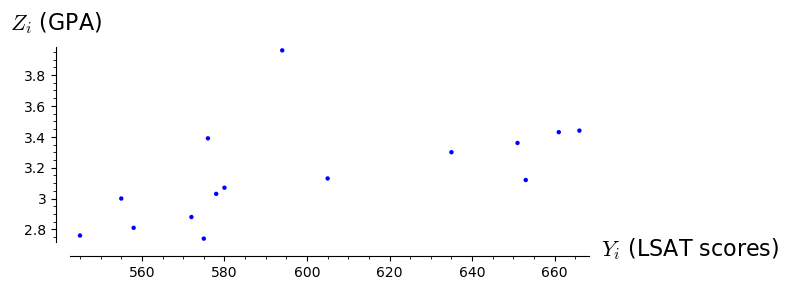

In [73]:
import numpy as np
LSAT=np.array([576, 635, 558, 578, 666, 580, 555, 661, 651, 605, 653, 575, 545, 572, 594]) # LSAT data
GPA=np.array([3.39, 3.30, 2.81, 3.03, 3.44, 3.07, 3.00, 3.43, 3.36, 3.13, 3.12, 2.74, 2.76, 2.88, 3.96]) # GPA data
# use np.vstack to vertically stack a sequence of arrays into a matrix of stacked rows
# see https://docs.scipy.org/doc/numpy/reference/generated/numpy.vstack.html#numpy.vstack
LSATGPA_data = np.vstack((LSAT,GPA)) # this is a 2D array of matric now
p = points(zip(LSATGPA_data[0,:],LSATGPA_data[1,:]))
p.show(figsize=(8,3),axes_labels=['$Y_i$ (LSAT scores)','$Z_i$ (GPA)'])

## Plug-in Point Estimate of the Correlation

The law school was interested in the **correlation** between the GPA and LSAT scores:

$$
\boxed{
\theta^* = \frac{\int \int (y-E(Y))(z-E(Z))dF(y,z)}{\sqrt{\int (y-E(Y))^2 dF(y) \int (z-E(Z))^2 dF(z)}}
}
$$

The *plug-in estimate of the population correlation* $\theta^*$ is the *sample correlation*:
$$
\boxed{
\widehat{\Theta}_n = \frac{\sum_{i=1}^n(Y_i-\overline{Y}_n)(Z_i-\overline{Z}_n)}{\sqrt{\sum_{i=1}^n(Y_i-\overline{Y}_n)^2 \sum_{i=1}^n(Z_i-\overline{Z}_n)^2}}
}
$$

In [75]:
# the sample correlation matrix, it's symmetric with diagonal elements as 1
SampleCorrelationMatrix = np.corrcoef(LSATGPA_data) 
print ("The Sample Correlation Matrix is")
print (SampleCorrelationMatrix)
print ("For a pair of variables we can extract the right entry of the symmetric Sample Correlation Matrix:")
SampleCorrelation_GPA_LSAT = SampleCorrelationMatrix[(0,1)]
print (SampleCorrelation_GPA_LSAT)

The Sample Correlation Matrix is
[[1.         0.54591892]
 [0.54591892 1.        ]]
For a pair of variables we can extract the right entry of the symmetric Sample Correlation Matrix:
0.5459189161795887


## The Bootstrapped $1-\alpha$ Confidence Interval of the Sample Correlation and a Test

In order to obtain the $1-\alpha$ confidence interval of the plug-in estimate of the population correlation, we can quickly tap into our function thousand bootstrapped data sets.

Then we can reject (or fail to reject) the null hypothesis that the true correlation coefficient is $0$ if $0$ is not contained in the bootstrapped 95% confidence interval (akin to a Wald Test, but with the nonparametric model).

In [77]:
# use the right lamba expression for the statistic of interest
statTSampleCorrCoeff = lambda dataMatrix : np.corrcoef(dataMatrix)[(0,1)] #statistic of interest
alpha=0.05
B=1000 # number of bootstrap samples
# get bootstrapped 1-alpha confidence Interval for statT99thPercentile
lowerCITcor,upperCITcor,bootValuesTcor = \
                 makeBootstrappedConfidenceIntervalOfStatisticT(LSATGPA_data, statTSampleCorrCoeff, alpha, B) 

if 0>=lowerCITcor and 0<=upperCITcor:
    print ("0 is inside the 1-alpha bootstrapped confidence interval for the correlation coefficient:")
    print ("   So, we fail to reject the Null Hypothesis that the population correlation coefficient = 0")
else:
    print ("0 is not inside the 1-alpha bootstrapped confidence interval for the correlation coefficient:")
    print ("   So, we reject the Null Hypothesis that the population correlation coefficient = 0")

0 is not inside the 1-alpha bootstrapped confidence interval for the correlation coefficient:
   So, we reject the Null Hypothesis that the population correlation coefficient = 0


## Why is testing whether correlation = 0 is of interest?
### Correlation Versus Causation - Proceed with Extreme Caution!

The following image from [https://en.wikipedia.org/wiki/Correlation_and_dependence](https://en.wikipedia.org/wiki/Correlation_and_dependence) shows:
> Several sets of (x, y) points, with the (Pearson's) correlation coefficient of x and y for each set. Note that the correlation reflects the noisiness and direction of a linear relationship (top row), but not the slope of that relationship (middle), nor many aspects of nonlinear relationships (bottom). N.B.: the figure in the center has a slope of 0 but in that case the correlation coefficient is undefined because the variance of Y is zero.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/d/d4/Correlation_examples2.svg/1200px-Correlation_examples2.svg.png" alt="Correlation examples2.svg">



# Nonparametric Hypothesis Testing 
## Are two samples from the same distribution or not?

What if we are not interested in estimating $F^*$ itself, but we are interested in scientificially investigating whether two distributions are the same.  For example, perhaps, whether the distribution of earthquake magnitudes was the same in April as it was in March or whether human subjects under a clinical trial are reacting differently two a new drug to treat some disease (typically you have a control group that does not get the treatment and the treated group).

You already have the means to do by using a Wald test of say the difference in sample means of the two samples, or correlation coefficient, etc for parametric or nonparametric experiments.

We will next see a useful nonparametric approach to this problem.


## Permutation Testing

A Permuation Test is a **non-parametric exact** method for testing whether two distributions are the same based on samples from each of them. In industry analogs and variants of permutation testing is known as *A/B Testing* in industry today.

What do we mean by "non-parametric exact"?  It is non-parametric because we do not impose any parametric assumptions.  It is exact because it works for any sample size.

Formally, we suppose that: 
$$ X_1,X_2,\ldots,X_m \overset{IID}{\sim} F^* \quad \text{and} \quad X_{m+1}, X_{m+2},\ldots,X_{m+n} \overset{IID}{\sim} G^* \enspace , $$
are two sets of independent samples where the possibly unknown DFs 
$F^*,\,G^* \in \{ \text{all DFs} \}$.

(Notice that we have written it so that the subscripts on the $X$s run from 1 to $m+n$.)

Now, consider the following hypothesis test: 
$$H_0: F^*=G^* \quad \text{versus} \quad H_1: F^* \neq G^* \enspace . $$

Our test statistic uses the observations in both both samples.  We want a test statistic that is a sensible one for the test, i.e., will be large when when $F^*$ is 'too different' from $G^*$

So, let our test statistic $T(X_1,\ldots,X_m,X_{m+1},\ldots,X_{m+n})$ be say: 
$$
T:=T(X_1,\ldots,X_m,X_{m+1},\ldots,X_{m+n})= \text{abs} \left( \frac{1}{m} \sum_{i=1}^m X_i - \frac{1}{n} \sum_{i=m+1}^n X_i \right) \enspace .
$$

(In words, we have chosen a test statistic that is the absolute value of the difference in the sample means.   Note the limitation of this:  if $F^*$ and $G^*$ have the same mean but different variances, our test statistic $T$ will not be large.)

Then the idea of a permutation test is as follows:

- Let $N:=m+n$ be the pooled sample size and consider all $N!$ permutations of the observed data $x_{obs}:=(x_1,x_2,\ldots,x_m,x_{m+1},x_{m+2},\ldots,x_{m+n})$.
- For each permutation of the data compute the statistic $T(\text{permuted data } x)$ and denote these $N!$ values of $T$ by $t_1,t_2,\ldots,t_{N!}$.
- Under $H_0: X_1,\ldots,X_m,X_{m+1},\ldots,X_{m+n} \overset{IID}{\sim}F^*=G^*$, each of the permutations of $x= (x_1,x_2,\ldots,x_m,x_{m+1},x_{m+2},\ldots,x_{m+n})$ has the same joint probability $\prod_{i=1}^{m+n} f(x_i)$, where $f(x_i)$ is the density function corresponding to $F^*=G^*$, $f(x_i)=dF(x_i)=dG(x_i)$. 
- Therefore, the transformation of the data by our statistic $T$ also has the same probability over the values of $T$, namely $\{t_1,t_2,\ldots,t_{N!}\}$. Let $\mathbf{P}_0$ be this permutation distribution under the null hypothesis. $\mathbf{P}_0$ is discrete and uniform over $\{t_1,t_2,\ldots,t_{N!}\}$. 
- Let $t_{obs} := T(x_{obs})$ be the observed value of the test statistic.
- Assuming we reject $H_0$ when $T$ is large, the P-value = $\mathbf{P}_0 \left( T \geq t_{obs} \right)$
- Saying that $\mathbf{P}_0$ is discrete and uniform over $\{t_1, t_2, \ldots, t_{N!}\}$ says that each possible permutation has an equal probabability of occuring (under the null hypothesis).  There are $N!$ possible permutations and so the probability of any individual permutation is $\frac{1}{N!}$

$$
\text{P-value} = \mathbf{P}_0 \left( T \geq t_{obs} \right) = \frac{1}{N!} \left( \sum_{j=1}^{N!} \mathbf{1} (t_j \geq t_{obs}) \right), \qquad \mathbf{1} (t_j \geq t_{obs}) = \begin{cases} 1 & \text{if } \quad t_j \geq t_{obs} \\ 0 & \text{otherwise} \end{cases}
$$

This will make more sense if we look at some real data. 

## Permutation Testing with Shell Data

In 2008, Guo Yaozong and Chen Shun collected data on the diameters of coarse venus shells from New Brighton beach for a course project.  They recorded the diameters for two samples of shells, one from each side of the New Brighton Pier.  The data is given in the following two cells.

*NOTE - Real Data for Really Applied Statistics*: Under my guidance and assistance, students collected the shells on either side of the pier, cleaned the shells with warm soap water, rinsed and and treated with a diluted chlorine solution, used a taxonomy guide to identify the mollusc species and classified them manually. Then they focused on *Dosinia anus* or coarse venus shells. After the diluted chlorine treatment to disinfect microflora/fauna, the shells were washed, dried, placed on a graph paper, etched around the base with a mechanical pencil, and finally measured with a scale for the largest diameter within the outline.

In [78]:
leftSide = [52, 54, 60, 60, 54, 47, 57, 58, 61, 57, 50, 60, 60, 60, 62, 44, 55, 58, 55,\
            60, 59, 65, 59, 63, 51, 61, 62, 61, 60, 61, 65, 43, 59, 58, 67, 56, 64, 47,\
            64, 60, 55, 58, 41, 53, 61, 60, 49, 48, 47, 42, 50, 58, 48, 59, 55, 59, 50, \
            47, 47, 33, 51, 61, 61, 52, 62, 64, 64, 47, 58, 58, 61, 50, 55, 47, 39, 59,\
            64, 63, 63, 62, 64, 61, 50, 62, 61, 65, 62, 66, 60, 59, 58, 58, 60, 59, 61,\
            55, 55, 62, 51, 61, 49, 52, 59, 60, 66, 50, 59, 64, 64, 62, 60, 65, 44, 58, 63]

In [79]:
rightSide = [58, 54, 60, 55, 56, 44, 60, 52, 57, 58, 61, 66, 56, 59, 49, 48, 69, 66, 49,\
             72, 49, 50, 59, 59, 59, 66, 62, 44, 49, 40, 59, 55, 61, 51, 62, 52, 63, 39,\
             63, 52, 62, 49, 48, 65, 68, 45, 63, 58, 55, 56, 55, 57, 34, 64, 66, 54, 65,\
             61, 56, 57, 59, 58, 62, 58, 40, 43, 62, 59, 64, 64, 65, 65, 59, 64, 63, 65,\
             62, 61, 47, 59, 63, 44, 43, 59, 67, 64, 60, 62, 64, 65, 59, 55, 38, 57, 61,\
             52, 61, 61, 60, 34, 62, 64, 58, 39, 63, 47, 55, 54, 48, 60, 55, 60, 65, 41,\
             61, 59, 65, 50, 54, 60, 48, 51, 68, 52, 51, 61, 57, 49, 51, 62, 63, 59, 62,\
             54, 59, 46, 64, 49, 61]

In [80]:
len(leftSide), len(rightSide)

(115, 139)

$(115 + 139)!$ is a very big number.   Lets start small, and take a subselection of the shell data to demonstrate the permutation test concept:  the first two shells from the left of the pier and the first one from the right:

In [81]:
rightSub = [52, 54]
leftSub = [58]
totalSample = rightSub + leftSub
totalSample

[52, 54, 58]

So now we are testing the hypotheses

$$\begin{array}{lcl}H_0&:& X_1,X_2,X_3 \overset{IID}{\sim} F^*=G^* \\H_1&:&X_1, X_2 \overset{IID}{\sim} F^*, \,\,X_3 \overset{IID}{\sim} G^*, F^* \neq G^*\end{array}$$ 

With the test statistic
$$\begin{array}{lcl}T(X_1,X_2,X_3) &=& \text{abs} \left(\displaystyle\frac{1}{2}\displaystyle\sum_{i=1}^2X_i - \displaystyle\frac{1}{1}\displaystyle\sum_{i=2+1}^3X_i\right) \\ &=&\text{abs}\left(\displaystyle\frac{X_1+ X_2}{2} - \displaystyle\frac{X_3}{1}\right)\end{array}$$

Our observed data $x_{obs} = (x_1, x_2, x_3) = (52, 54, 58)$

and the realisation of the test statistic for this data is $t_{obs} = \text{abs}\left(\displaystyle\frac{52+54}{2} - \frac{58}{1}\right) = \text{abs}\left(53 - 58\right) = \text{abs}(-5) = 5$

Now we need to tabulate the permutations and their probabilities.  There are 3! = 6 possible permutataions of three items.  For larger samples, you could use the `factorial` function to calculate this:

In [82]:
factorial(3)

6

We said that under the null hypotheses (the samples have the same DF) each permutation is equally likely, so each permutation has probability $\displaystyle\frac{1}{6}$.

There is a way in Python (the language under the hood in Sage), to get all the permuations of a sequence:

In [83]:
list(Permutations(totalSample))

[[52, 54, 58],
 [52, 58, 54],
 [54, 52, 58],
 [54, 58, 52],
 [58, 52, 54],
 [58, 54, 52]]

We can tabulate the permuations, their probabilities, and the value of the test statistic that would be associated with that permutation:

<table border="1" cellpadding="5" align="center">
<tbody>
<tr>
<td style="text-align: center;">Permutation</td>
<td style="text-align: center;">$t$</td>
<td style="text-align: center;">$\mathbf{P}_0(T=t)$</td>
</tr>
<tr>
<td style="text-align: center;"> </td>
<td style="text-align: center;"> </td>
<td style="text-align: center;">Probability under Null</td>
</tr>
<tr>
<td style="text-align: center;">(52, 54, 58)</td>
<td style="text-align: center;">5</td>
<td style="text-align: center;">$\frac{1}{6}$</td>
</tr>
<tr>
<td style="text-align: center;">(52, 58, 54)</td>
<td style="text-align: center;">&nbsp;1</td>
<td style="text-align: center;">$\frac{1}{6}$</td>
</tr>
<tr>
<td style="text-align: center;">(54, 52, 58)</td>
<td style="text-align: center;">5</td>
<td style="text-align: center;">$\frac{1}{6}$</td>
</tr>
<tr>
<td style="text-align: center;">(54, 58, 52)</td>
<td style="text-align: center;">4</td>
<td style="text-align: center;">$\frac{1}{6}$</td>
</tr>
<tr>
<td style="text-align: center;">(58, 52, 54)</td>
<td style="text-align: center;">1</td>
<td style="text-align: center;">$\frac{1}{6}$</td>
</tr>
<tr>
<td style="text-align: center;">(58, 54, 52)</td>
<td style="text-align: center;">4</td>
<td style="text-align: center;">$\frac{1}{6}$</td>
</tr>
</tbody>
</table>

In [85]:
allPerms = list(Permutations(totalSample))
for p in allPerms:
    t = abs((p[0] + p[1])/2 - p[2]/1)
    print (p, " has t = ", t)

[52, 54, 58]  has t =  5
[52, 58, 54]  has t =  1
[54, 52, 58]  has t =  5
[54, 58, 52]  has t =  4
[58, 52, 54]  has t =  1
[58, 54, 52]  has t =  4


To calculate the P-value for our test statistic $t_{obs} = 5$, we need to look at how many permutations would give rise to test statistics that are at least as big, and add up their probabilities.

$$
\begin{array}{lcl}\text{P-value} &=& \mathbf{P}_0(T \geq t_{obs}) \\&=&\mathbf{P}_0(T \geq 5)\\&=&\frac{1}{6} + \frac {1}{6} \\&=&\frac{2}{6}\\ &=&\frac{1}{3} \\ &\approx & 0.333\end{array}
$$

We could write ourselves a little bit of code to do this in SageMath.  As you can see, we could easily improve this to make it more flexible so that we could use it for different numbers of samples, but it will do for now.

In [86]:
allPerms = list(Permutations(totalSample))
pProb = 1/len(allPerms)
pValue = 0
tobs = 5
for p in allPerms:
    t = abs((p[0] + p[1])/2 - p[2]/1)
    if t >= tobs:
        pValue = pValue + pProb
pValue

1/3

This means that there is little or no evidence against the null hypothesis (that the shell diameter observations are from the same DF).

### Pooled sample size

The lowest possible P-value for a pooled sample of size $N=m+n$ is $\displaystyle\frac{1}{N!}$.  Can you see why this is? 

So with our small sub-samples the smallest possible P-value would be $\frac{1}{6} \approx 0.167$.  If we are looking for P-value $\leq 0.01$ to constitute very strong evidence against $H_0$, then we have to have a large enough pooled sample for this to be possible.  Since $5! = 5 \times 4 \times 3 \times 2 \times 1 = 120$, it is good to have $N \geq 5$

### YouTry in class

Try copying and pasting our code and then adapting it to deal with a sub-sample (52, 54, 60) from the left of the pier and (58, 54) from the right side of the pier.  

In [87]:
rightSub = [52, 54, 60]
leftSub = [58, 54]
totalSample = rightSub + leftSub
totalSample

[52, 54, 60, 58, 54]

### You will have to think about:

- calculating the value of the test statistic for the observed data and for all the permuations of the total sample
- calculating the probability of each permutation
- calculating the P-value by adding the probabilities for the permutations with test statistics at least as large as the observed value of the test statistic

(add more cells if you need them)

(end of You Try)

---

We can use the sample function and the Python method for making permutations to experiment with a larger sample, say 5 of each.

In [88]:
n, m = 5, 5
leftSub = sample(leftSide, n)
rightSub = sample(rightSide,m)
totalSample = leftSub + rightSub
leftSub; rightSub; totalSample

[62, 58, 58, 50, 61, 62, 64, 49, 44, 52]

In [89]:
tobs = abs(mean(leftSub) - mean(rightSub))
tobs

18/5

We have met sample briefly already:  it is part of the Python random module and it does exactly what you would expect from the name: it samples a specified number of elements randomly from a sequence.

In [90]:
#define a helper function for calculating the tstat from a permutation
def tForPerm(perm, samplesize1, samplesize2):
    '''Calculates the t statistic for a permutation of data given the sample sizes to split the permuation into.
    
    Param perm is the permutation of data to be split into the two samples.
    Param samplesize1, samplesize2 are the two sample sizes.
    Returns the absolute value of the difference in the means of the two samples split out from perm.'''
    sample1 = [perm[i] for i in range(samplesize1)]
    sample2 = [perm[samplesize1+j] for j in range(samplesize2)]
    return abs(mean(sample1) - mean(sample2))

In [91]:
allPerms = list(Permutations(totalSample))
pProb = 1/len(allPerms)
pValue = 0
tobs = abs(mean(leftSub) - mean(rightSub))
for p in allPerms:
    t = tForPerm(p, n, m)
    if t >= tobs:
        pValue = pValue + pProb
pValue

10/21

In [92]:
n+m

10

In [93]:
factorial(n+m) # how many permutations is it checking

3628800

As you can see from the length of time it takes to do the calculation for $(5+5)! = 10!$ permutations, we will be here a long time if we try to this on all of the two shell data sets.  

#### Monte Carlo methods to the rescue! 
We can use Monte Carlo integration to calculate an approximate P-value, and this will be our next topic. 

 

### You try

Try working out the P-value for a sub-sample (58, 63) from the left of the pier and (61) from the right (the two last values in the left-side data set and the last value in the right-side one).  Do it as you would if given a similar question in the exam: you choose how much you want to use Sage to help and how much you do just with pen and paper. 

### Example: Permutation test for shell diameters using the bootsrapped/permuted confidence interval

In [95]:
print (leftSide) # shell diameters on left side of pier
print (rightSide) # on right side
print (len(leftSide), len(rightSide))
shellDiameterDataArray = np.array(leftSide + rightSide) # concatenate as np.array, observed data
shellDiameterDataArray


[52, 54, 60, 60, 54, 47, 57, 58, 61, 57, 50, 60, 60, 60, 62, 44, 55, 58, 55, 60, 59, 65, 59, 63, 51, 61, 62, 61, 60, 61, 65, 43, 59, 58, 67, 56, 64, 47, 64, 60, 55, 58, 41, 53, 61, 60, 49, 48, 47, 42, 50, 58, 48, 59, 55, 59, 50, 47, 47, 33, 51, 61, 61, 52, 62, 64, 64, 47, 58, 58, 61, 50, 55, 47, 39, 59, 64, 63, 63, 62, 64, 61, 50, 62, 61, 65, 62, 66, 60, 59, 58, 58, 60, 59, 61, 55, 55, 62, 51, 61, 49, 52, 59, 60, 66, 50, 59, 64, 64, 62, 60, 65, 44, 58, 63]
[58, 54, 60, 55, 56, 44, 60, 52, 57, 58, 61, 66, 56, 59, 49, 48, 69, 66, 49, 72, 49, 50, 59, 59, 59, 66, 62, 44, 49, 40, 59, 55, 61, 51, 62, 52, 63, 39, 63, 52, 62, 49, 48, 65, 68, 45, 63, 58, 55, 56, 55, 57, 34, 64, 66, 54, 65, 61, 56, 57, 59, 58, 62, 58, 40, 43, 62, 59, 64, 64, 65, 65, 59, 64, 63, 65, 62, 61, 47, 59, 63, 44, 43, 59, 67, 64, 60, 62, 64, 65, 59, 55, 38, 57, 61, 52, 61, 61, 60, 34, 62, 64, 58, 39, 63, 47, 55, 54, 48, 60, 55, 60, 65, 41, 61, 59, 65, 50, 54, 60, 48, 51, 68, 52, 51, 61, 57, 49, 51, 62, 63, 59, 62, 54, 59

array([52, 54, 60, 60, 54, 47, 57, 58, 61, 57, 50, 60, 60, 60, 62, 44, 55,
       58, 55, 60, 59, 65, 59, 63, 51, 61, 62, 61, 60, 61, 65, 43, 59, 58,
       67, 56, 64, 47, 64, 60, 55, 58, 41, 53, 61, 60, 49, 48, 47, 42, 50,
       58, 48, 59, 55, 59, 50, 47, 47, 33, 51, 61, 61, 52, 62, 64, 64, 47,
       58, 58, 61, 50, 55, 47, 39, 59, 64, 63, 63, 62, 64, 61, 50, 62, 61,
       65, 62, 66, 60, 59, 58, 58, 60, 59, 61, 55, 55, 62, 51, 61, 49, 52,
       59, 60, 66, 50, 59, 64, 64, 62, 60, 65, 44, 58, 63, 58, 54, 60, 55,
       56, 44, 60, 52, 57, 58, 61, 66, 56, 59, 49, 48, 69, 66, 49, 72, 49,
       50, 59, 59, 59, 66, 62, 44, 49, 40, 59, 55, 61, 51, 62, 52, 63, 39,
       63, 52, 62, 49, 48, 65, 68, 45, 63, 58, 55, 56, 55, 57, 34, 64, 66,
       54, 65, 61, 56, 57, 59, 58, 62, 58, 40, 43, 62, 59, 64, 64, 65, 65,
       59, 64, 63, 65, 62, 61, 47, 59, 63, 44, 43, 59, 67, 64, 60, 62, 64,
       65, 59, 55, 38, 57, 61, 52, 61, 61, 60, 34, 62, 64, 58, 39, 63, 47,
       55, 54, 48, 60, 55

In [96]:
print (shellDiameterDataArray[0:115]) # left diameters
print (shellDiameterDataArray[0:115].mean()) # mean of left side
print (shellDiameterDataArray[115:115+139]) # right diameters
print (shellDiameterDataArray[115:115+139].mean()) # mean of right side

[52 54 60 60 54 47 57 58 61 57 50 60 60 60 62 44 55 58 55 60 59 65 59 63
 51 61 62 61 60 61 65 43 59 58 67 56 64 47 64 60 55 58 41 53 61 60 49 48
 47 42 50 58 48 59 55 59 50 47 47 33 51 61 61 52 62 64 64 47 58 58 61 50
 55 47 39 59 64 63 63 62 64 61 50 62 61 65 62 66 60 59 58 58 60 59 61 55
 55 62 51 61 49 52 59 60 66 50 59 64 64 62 60 65 44 58 63]
56.82608695652174
[58 54 60 55 56 44 60 52 57 58 61 66 56 59 49 48 69 66 49 72 49 50 59 59
 59 66 62 44 49 40 59 55 61 51 62 52 63 39 63 52 62 49 48 65 68 45 63 58
 55 56 55 57 34 64 66 54 65 61 56 57 59 58 62 58 40 43 62 59 64 64 65 65
 59 64 63 65 62 61 47 59 63 44 43 59 67 64 60 62 64 65 59 55 38 57 61 52
 61 61 60 34 62 64 58 39 63 47 55 54 48 60 55 60 65 41 61 59 65 50 54 60
 48 51 68 52 51 61 57 49 51 62 63 59 62 54 59 46 64 49 61]
56.66187050359712


In [97]:
observedTestStat = np.abs(shellDiameterDataArray[0:115].mean() - shellDiameterDataArray[115:115+139].mean())
observedTestStat


0.16421645292462017

In [98]:
# use the right lamba expression for the statistic of interest
TestStat = \
          lambda dataArray : np.abs(dataArray[0:115].mean() - dataArray[115:115+139].mean())
observedTestStat = TestStat(shellDiameterDataArray)
observedTestStat 

0.16421645292462017

In [102]:
np.array(sample(list(shellDiameterDataArray),115+139)) 
# resample from concatenated data to bootstrap TestStat under H_0

array([55, 58, 54, 64, 60, 64, 50, 55, 59, 59, 54, 46, 65, 51, 58, 62, 72,
       54, 62, 59, 59, 44, 49, 34, 60, 57, 61, 44, 60, 42, 59, 40, 60, 65,
       61, 58, 55, 59, 59, 55, 48, 51, 59, 38, 60, 60, 50, 66, 50, 62, 60,
       59, 58, 60, 61, 52, 65, 57, 57, 59, 59, 49, 61, 64, 64, 59, 60, 61,
       60, 57, 61, 64, 34, 49, 62, 61, 63, 47, 59, 64, 50, 54, 55, 58, 61,
       52, 54, 63, 55, 58, 57, 60, 47, 55, 50, 58, 63, 65, 61, 61, 65, 58,
       49, 65, 39, 59, 58, 62, 54, 67, 60, 47, 49, 60, 56, 63, 62, 62, 60,
       59, 64, 61, 58, 59, 56, 65, 50, 62, 63, 45, 60, 51, 51, 64, 51, 64,
       63, 66, 55, 57, 66, 58, 33, 47, 62, 68, 61, 52, 59, 59, 64, 49, 52,
       63, 48, 61, 61, 59, 58, 65, 48, 56, 62, 62, 55, 61, 60, 61, 63, 53,
       52, 58, 59, 62, 43, 66, 61, 62, 52, 47, 55, 39, 41, 55, 59, 43, 62,
       61, 55, 58, 59, 44, 64, 47, 62, 50, 60, 65, 56, 63, 62, 41, 58, 49,
       62, 54, 61, 63, 64, 48, 55, 51, 55, 43, 52, 65, 58, 67, 63, 68, 52,
       60, 64, 61, 61, 47

In [119]:
alpha=0.05
B=100 # number of bootstrap samples for estimating p-value in a permutation test / or bootstrapped as per 'sample'

bootstrappedTestStats=[]
for i in range(B):
    # sample from concatenated data to bootstrap or permute as per 'sample(...)' function's behaviour
    permutedBootstrappedData = np.array(sample(list(shellDiameterDataArray),115+139)) 
    #print i, permutedBootstrappedData
    bootstrappedTestStats.append(TestStat(permutedBootstrappedData))
    
bootstrappedTestStatsArray=np.array(bootstrappedTestStats)

print ("observed Test Statistics = ", observedTestStat)
#print bootstrappedTestStats

alpaAsPercentage=alpha*100.0
lowerBootstrap1MinusAlphaCIForStatisticT = np.percentile(bootstrappedTestStats,alpaAsPercentage/2)
upperBootstrap1MinusAlphaCIForStatisticT = np.percentile(bootstrappedTestStats,100-alpaAsPercentage/2)

print ("The inner (1 - "+str(alpha)+" ) percentile based Confidence Interval for the statistic T = ")
print ("  [ "+str(lowerBootstrap1MinusAlphaCIForStatisticT)+"," +str(upperBootstrap1MinusAlphaCIForStatisticT)+" ]")



observed Test Statistics =  0.16421645292462017
The inner (1 - 0.0500000000000000 ) percentile based Confidence Interval for the statistic T = 
  [ 0.023703472005003334,2.1553112292774443 ]


### So do we reject the Null Hypothesis that the diameters were the same on either side of the New Brighton Pier?

To answer this question we simply need to see whether the observed Test Statistic of the absolute difference between the sample means between the left and right side of the pier lies:
 - inside the 95% permuted/bootstrapped confidence interval?
 - or outside?
 
We can conclude that there is no evidence to reject the null hypothesis because $0.164216452925 \in [0.05, 0.82]$. And therefore the inviduals of *Dosinia anus* have the same distribution on either side of the Pier.
